# Fitting Distributions to a Dataset 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ipywidgets import interact, interact_manual
import os

In [2]:
#Read in statistical distribution data
continuous_distributions = "https://raw.githubusercontent.com/jdorvi/MonteCarlos_SLC/master/continuous_distributions_.csv"
dists_unindexed = pd.read_csv(continuous_distributions)
dist_list = dists_unindexed.distribution.tolist()
dists = dists_unindexed.set_index(dists_unindexed.distribution)

### Import Data

In [9]:
#Sample Data File
filename = 'https://raw.githubusercontent.com/jdorvi/MonteCarlos_SLC/master/montauk_combined_data.csv'

#Read in data
df = pd.read_csv(f, sep = ',').dropna()  
df.columns = df.columns.str.strip()
df.drop(labels= ['start','end'],axis = 1,  inplace = True)
title = str(f).split('/')[-1]

df.head()

,length,inter,swel,hsig,tps,a_hsig,a_tps
0,34,71,0.26,4.04,10.00,3.61,9.01
1,20,63,0.40,5.54,9.09,4.01,9.15
2,5,152,-0.34,3.71,7.69,3.45,7.95
3,13,251,0.09,4.96,10.00,3.93,9.05
4,6,52,0.05,3.57,9.09,3.35,8.50


In [10]:
def save_figure(path,name):
    plt.savefig(path+name+".png",
                dpi=200,
                facecolor='none',
                edgecolor='none'
               )

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def dist_fit(name,dist_name,bins,parameter):
    import numpy as np
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import gridspec
    import scipy.stats as stats
    import scipy
    global df
    #Initialize figure and set dimensions
    fig = plt.figure(figsize = (18,6))
    gs = gridspec.GridSpec(2,2)
    ax1 = fig.add_subplot(gs[:,0])
    ax3 = fig.add_subplot(gs[:,1])
    ax1.set_title(title,fontsize=20)
    
    #Remove the plot frame lines. They are unnecessary chartjunk.
    ax1.spines["top"].set_visible(False)  
    ax1.spines["right"].set_visible(False) 
    ax3.spines["top"].set_visible(False)  
    ax3.spines["right"].set_visible(False) 
    
    # Ensure that the axis ticks only show up on the bottom and left of the plot.  
    # Ticks on the right and top of the plot are generally unnecessary chartjunk.  
    ax1.get_xaxis().tick_bottom()  
    ax1.get_yaxis().tick_left()  
    ax3.get_xaxis().tick_bottom()  
    ax3.get_yaxis().tick_left()  
    
    # Make sure your axis ticks are large enough to be easily read.  
    # You don't want your viewers squinting to read your plot.  
    ax1.tick_params(axis="both", which="both", bottom="off", top="off",  
                    labelbottom="on", left="on", right="off", labelleft="on",labelsize=14)
    ax3.tick_params(axis="both", which="both", bottom="off", top="off",  
                    labelbottom="on", left="on", right="off", labelleft="on",labelsize=14)

    # Along the same vein, make sure your axis labels are large  
    # enough to be easily read as well. Make them slightly larger  
    # than your axis tick labels so they stand out.  
    ax1.set_xlabel(parameter, fontsize=16)  
    ax1.set_ylabel("Frequency of occurence", fontsize=16)  
    ax3.set_xlabel(parameter, fontsize=16) 
    ax3.set_ylabel("Exceedance Probability", fontsize=16)
    #Setting .... variables
    size    = len(df[parameter])
    max_val = 1.1*max(df[parameter])
    min_val = min(df[parameter])
    range_val = max_val-min_val
    binsize = range_val/bins
    x0 = np.arange(min_val,max_val,range_val*0.0001)
    x1 = np.arange(min_val,max_val,binsize)
    y1 = df[parameter]
    #set x-axis limits
    ax1.set_xlim(min_val,max_val)
    ax3.set_xlim(min_val,max_val)
    ax3.set_ylim(0,1.1)
    #Plot histograms
    EPDF = ax1.hist(y1, bins=x1, color='w')
    ECDF = ax3.hist(y1, bins=x1, color='w', normed=1, cumulative=True)
    #Fitting distribution
    dist  = getattr(scipy.stats, dist_name)
    param = dist.fit(y1)
    pdf_fitted = dist.pdf(x0, *param[:-2], loc=param[-2], scale=param[-1])*size*binsize
    cdf_fitted = dist.cdf(x0, *param[:-2], loc=param[-2], scale=param[-1])
    
    #Checking goodness of fit
    #ks_fit = stats.kstest(pdf_fitted,dist_name) # Kolmogorov-Smirnov test: returns [KS stat (D,D+,orD-),pvalue]
    #print(ks_fit)
    
    #Finding location of 0.002 and 0.01 exceedence probability events 
    FiveHundInd = find_nearest(cdf_fitted,0.998)
    OneHundInd  = find_nearest(cdf_fitted,0.990)
    #Plotting pdf and cdf    
    ax1.plot(x0,pdf_fitted,linewidth=2,label=dist_name)
    ax3.plot(x0,cdf_fitted,linewidth=2,label=dist_name)
    #update figure spacing
    gs.update(wspace=0.1, hspace=0.2)
    #adding a text box
    ax3.text(min_val+0.1*range_val,1.1,
             dist_name.upper()+" distribution\n"
             +"\n"
             +"0.2% - value: " + str("%.2f" %x0[FiveHundInd])+ " meters\n"
             +"1.0% - value: " + str("%.2f" %x0[OneHundInd]) + " meters",
             fontsize=14
            )

    print(dists.loc[dist_name,'description']+"\n")
    
    param_names = (dist.shapes + ', loc, scale').split(', ') if dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, param)])
    dist_str = '{}({})'.format(dist_name, param_str)
    print(dist_str)
    plt.show()
    print(stats.kstest(y1,dist_name,param,alternative='less'))
    print(stats.kstest(y1,dist_name,param,alternative='greater'))
    print(stats.kstest(y1,dist_name,param,alternative='two-sided'))
    return name

An exponential continuous random variable.

expon(loc=3.05, scale=1.11)


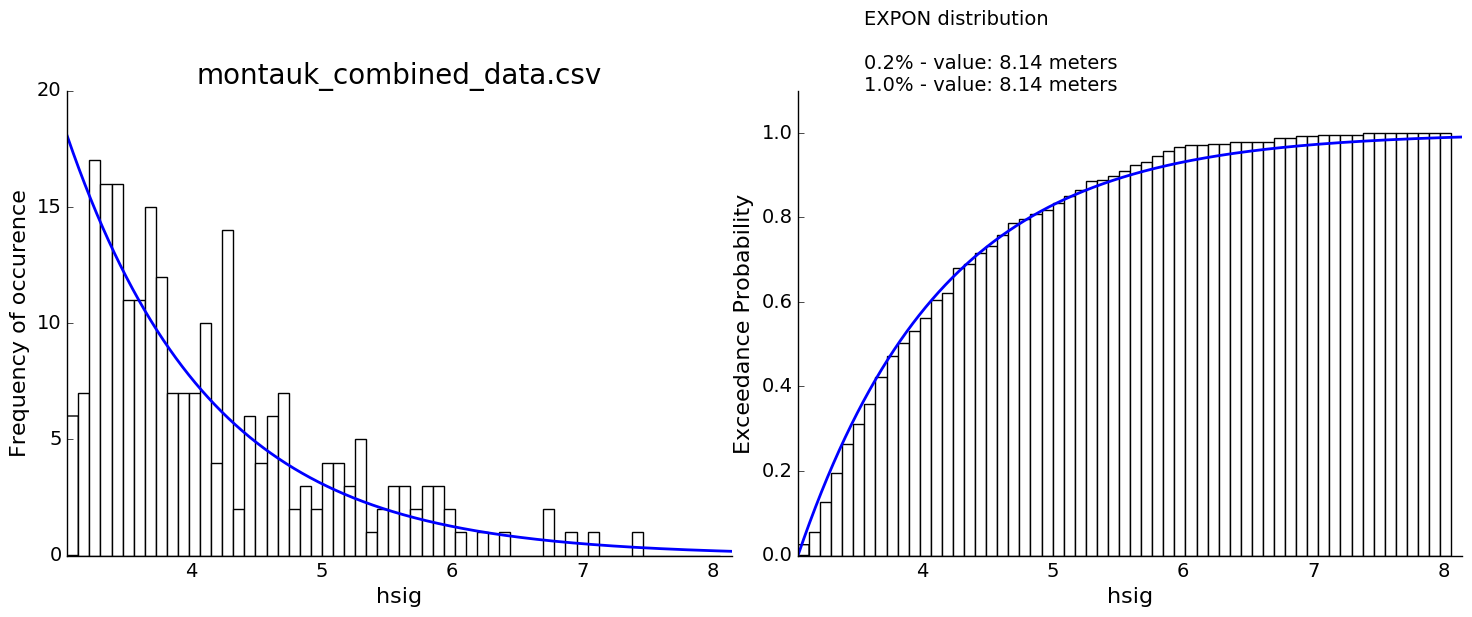

KstestResult(statistic=0.087978934152572671, pvalue=0.024735082930688823)
KstestResult(statistic=0.034628297544446407, pvalue=0.55639060622862668)
KstestResult(statistic=0.087978934152572671, pvalue=0.049470165861377646)


'https://raw.githubusercontent.com/jdorvi/MonteCarlos_SLC/master/montauk_combined_data.csv'

In [11]:
params = list(df.columns) 
interact_manual(dist_fit, name=f, dist_name=dist_list, bins=[25,100,5],parameter=params,title=title)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3f335fc278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3f30e60e80>]], dtype=object)

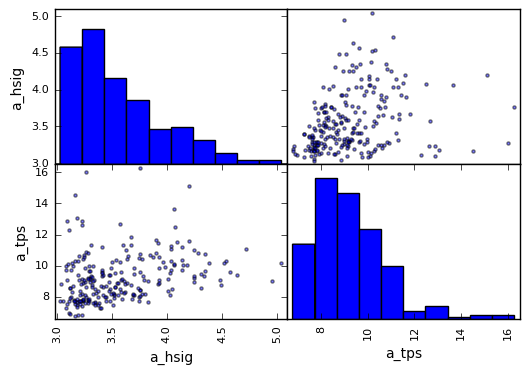

In [7]:
#Choose data vectors for scatter matrix
usecols = ['a_hsig','a_tps']
stat_data = df[usecols]
pd.tools.plotting.scatter_matrix(stat_data)


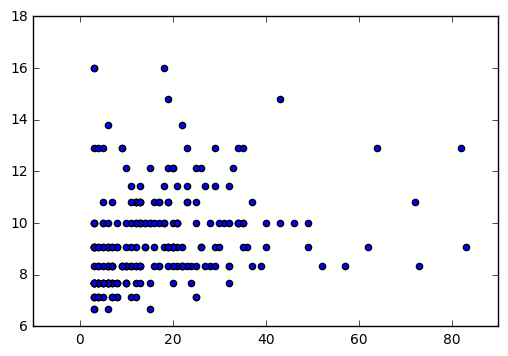

In [8]:
#Scatter Plot using 2 variables from dataset

x,y = df.length,df.tps

plt.scatter(x,y)

   ###References:
   Python <br\>
   http://stackoverflow.com/questions/6615489/fitting-distributions-goodness-of-fit-p-value-is-it-possible-to-do-this-with/16651524#16651524 <br\>
   http://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python <br\><br\>
   Extreme wave statistics <br\>
   http://drs.nio.org/drs/bitstream/handle/2264/4165/Nat_Hazards_64_223a.pdf;jsessionid=55AAEDE5A2BF3AA06C6CCB5CE3CBEBAD?sequence=1 <br\><br\>
   List of available distributions can be found here <br\>
   http://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions<br\><br\>
   Goodness of fit tests <br\>
   http://statsmodels.sourceforge.net/stable/stats.html#goodness-of-fit-tests-and-measures <br\>
   http://docs.scipy.org/doc/scipy/reference/stats.html#statistical-functions <br\>

Length<br>
genexpon(a=1.38, b=0.20, c=0.03, loc=3.00, scale=19.39)<br>
KstestResult(statistic=0.090090090087017877, pvalue=0.051121878132879051)<br>
genpareto(c=-0.02, loc=3.00, scale=14.16)<br>
KstestResult(statistic=0.08997375153682749, pvalue=0.051604871224521176)<br><br>

Interim<br>
foldcauchy(c=0.63, loc=25.94, scale=137.16)
KstestResult(statistic=0.026999638083165967, pvalue=0.99705005373423183)

SWEL<br>
johnsonsb(a=-0.95, b=1.41, loc=-1.12, scale=1.90)<br> 
KstestResult(statistic=0.029574404259407161, pvalue=0.9901000531575973)<br><br>

HSIG<br>
genexpon(a=0.05, b=0.32, c=1.83, loc=3.05, scale=0.36)<br>
KstestResult(statistic=0.041869945686266341, pvalue=0.83122014943398015)<br>
exponnorm(K=12.76, loc=3.16, scale=0.08)<br>
KstestResult(statistic=0.045765702677044495, pvalue=0.74112752318380581)<br><br>

TPS<br>
recipinvgauss(mu=0.24, loc=5.60, scale=0.74)<br>
KstestResult(statistic=0.10435298093410683, pvalue=0.014720986714411577)<br>
genextreme(c=-0.08, loc=8.58, scale=1.31)<br>
KstestResult(statistic=0.11307745876143599, pvalue=0.0062809593607968672)<br><br>

a_hsig<br>
genexpon(a=0.22, b=2.34, c=7.13, loc=3.03, scale=1.09)<br>
KstestResult(statistic=0.047691926585930133, pvalue=0.70607193161667459)<br>
exponnorm(K=8.97, loc=3.11, scale=0.05)<br>
KstestResult(statistic=0.050605085052604193, pvalue=0.62055905806032152)<br><br>

a_tps<br>
recipinvgauss(mu=0.22, loc=5.90, scale=0.61)<br>
KstestResult(statistic=0.038004922394594909, pvalue=0.90556531830166975)<br>
genextreme(c=-0.08, loc=8.55, scale=1.12)<br>
KstestResult(statistic=0.045956458061729433, pvalue=0.73647282485448418)<br><br>
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    